# Phenosim clustering tutorial
This notebook will outline methods to show how use phenosim to cluster groups of simulated patients with phenotypes from a few diseases.

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from itertools import product
from phenosim.obo import restore
from phenosim.score import Scorer

import urllib

In [2]:
# restore will only work once an hpo_network.pickle file has been created.
# This file is created by running command-line phenosim at least once.
phenosim_data_directory = os.path.join(os.getenv('HOME'), '.phenosim/data')
hpo = restore(os.path.join(phenosim_data_directory, 'hpo_network.pickle'))
scorer = Scorer(hpo)

When comparing phenotypes from different phenotypic series defined in OMIM, the two groups should cluster separately. The two phenotypic series used for demonstration are `PS164400: Spinocerebellar ataxia` and `PS118220: Charcot-Marie-tooth`.

In [3]:
# Use the HPO's publicly available disease to phenotype mapping file.
disease_phenotype_file = 'http://compbio.charite.de/jenkins/job/hpo.annotations/lastStableBuild/artifact/misc/phenotype_annotation_new.tab'

In [4]:
response = urllib.request.urlopen(disease_phenotype_file)

In [5]:
disease1 = {}
disease2 = {}
disease3 = {}

for line in response:
    try:
        row = line.decode('utf-8').split('\t')
        db = row[0]
        db_object_id = row[1]
        db_name = row[2]
        hpo_id = row[4]
    except IndexError:
        continue
    
    if db == 'OMIM':
        if 'charcot-marie-tooth' in db_name.lower():
            if db_object_id in disease1:
                disease1[db_object_id].append(hpo_id)
            else:
                disease1[db_object_id] = [hpo_id]
        elif 'spinocerebellar ataxia' in db_name.lower():
            if db_object_id in disease2:
                disease2[db_object_id].append(hpo_id)
            else:
                disease2[db_object_id] = [hpo_id]
        elif 'bardet-biedl' in db_name.lower():
            if db_object_id in disease3:
                disease3[db_object_id].append(hpo_id)
            else:
                disease3[db_object_id] = [hpo_id]

In [6]:
print(f'Number of diseases in the CMT series: {len(disease1)}')
print(f'Number of diseases in the SCA series: {len(disease2)}')
print(f'Number of diseases in the BBS series: {len(disease3)}')

Number of diseases in the CMT series: 69
Number of diseases in the SCA series: 74
Number of diseases in the BBS series: 21


In [7]:
diseases = {**disease1, **disease2, **disease3}

In [8]:
remove_these = []
for omim in diseases:
    if len(diseases[omim]) < 5:
        remove_these.append(omim)
        
for omim in remove_these:
    diseases.pop(omim)

In [9]:
print(f'Number of diseases with both series combined: {len(diseases)}')

Number of diseases with both series combined: 161


### Perform pairwise comparisons of phenotypic similarity for all disease records

In [10]:
def convert_and_filter_hpoids(terms, hpo, scorer):
    """Given a list of HPO ids, first try to convert synonyms to primary ids, 
    then filter if terms are not in the ontology"""
    terms = [scorer.alt2prim[term] if term in scorer.alt2prim else term for term in terms]
    terms = list(filter(lambda term: term in hpo.nodes, terms))
    return terms

In [11]:
records_product = product(diseases.keys(), repeat=2)

### The next two cells highlight the speedup difference between using the imported library and the command-line tool with multiple threads.

1: Using `scorer.score()`

In [12]:
%%time
# score in a simple for-loop, this cell executes in ~2min
results = []
for record1, record2 in records_product:
    terms_1 = convert_and_filter_hpoids(diseases[record1], hpo, scorer)
    terms_2 = convert_and_filter_hpoids(diseases[record2], hpo, scorer)
    results.append((record1, record2, scorer.score(terms_1, terms_2)))

CPU times: user 2min 26s, sys: 472 ms, total: 2min 27s
Wall time: 2min 27s


2: Using the command line tool to score the product of these 

In [13]:
#%%time
#records_product = product(diseases.keys(), repeat=2)
#from subprocess import run
#results = run(["phenosim", "score-product", "../tests/data/test.score-product.txt", "--threads=8"], capture_output=True)

### Plot the pairwise phenotypic similarity results

In [14]:
df = pd.DataFrame(results, columns=['record1', 'record2', 'phenosim-score'])
# convert to square form
df = df.set_index(['record1', 'record2']).unstack()

In [16]:
# get the disease label for each id
colors = {}
color_labels = {
    'r': 'Charcot-Marie-Tooth',
    'b': 'Spinocerebellar Ataxia',
    'g': 'Bardet-Biedl',
}
for omim in df.index:
    if omim in disease1:
        colors[omim] = 'r'
    elif omim in disease2:
        colors[omim] = 'b'
    elif omim in disease3:
        colors[omim] = 'g'

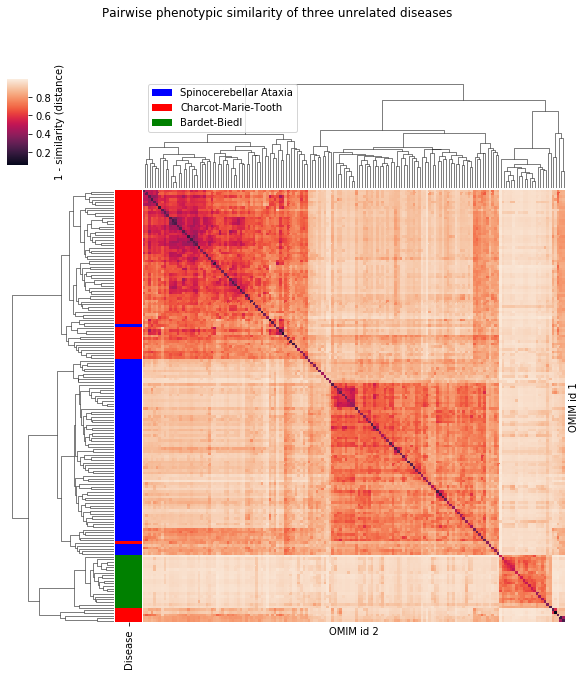

In [17]:
# 1 - df converts the similarity to a distance metric
g = sns.clustermap(1 - df, 
                   row_colors=pd.Series(colors, name="Disease"), 
                   figsize=(10, 10),
                   xticklabels=False, 
                   yticklabels=False,
                   cbar_kws={'label': '1 - similarity (distance)'}
                   
                  )
for label in pd.Series(colors).unique():
    g.ax_col_dendrogram.bar(0, 0, color=label,
                            label=color_labels[label], linewidth=0)

g.ax_heatmap.set_xlabel("OMIM id 2");
g.ax_heatmap.set_ylabel("OMIM id 1");
g.ax_col_dendrogram.legend(loc="upper left");
g.fig.suptitle('Pairwise phenotypic similarity of three unrelated diseases');
plt.savefig('output/cluster_three_diseases.png', format='png');